In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, OrdinalEncoder

In [2]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
sample_submission = pd.read_csv("sample_submission.csv", index_col=0)

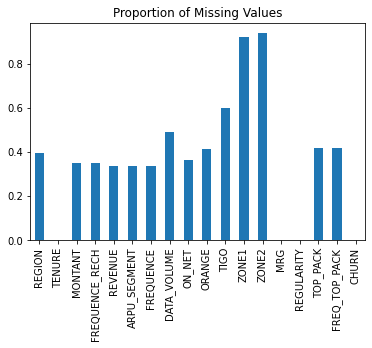

In [3]:
missing = (train.isna().sum() / train.shape[0]).plot.bar()
_ = missing.set_title("Proportion of Missing Values")

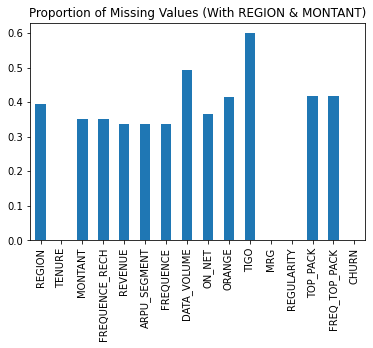

In [4]:
train.drop(["ZONE1", "ZONE2"], axis=1, inplace=True)
test.drop(["ZONE1", "ZONE2"], axis=1, inplace=True)

missing = (train.isna().sum() / train.shape[0]).plot.bar()
_ = missing.set_title("Proportion of Missing Values (With REGION & MONTANT)")

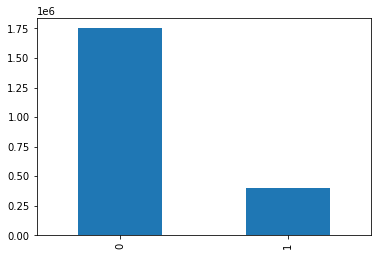

In [5]:
train["CHURN"].value_counts().plot.bar()

In [6]:
categorical_features = ["REGION"]
numeric_features = [
    "MONTANT", "FREQUENCE_RECH", "REVENUE", "ARPU_SEGMENT", "FREQUENCE",
    "DATA_VOLUME", "ON_NET", "ORANGE", "TIGO", "REGULARITY", "FREQ_TOP_PACK"
]

categorical_preprocess = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OrdinalEncoder())
])

numeric_preprocess = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("rescale", QuantileTransformer(output_distribution="normal")),
    ("dim_reduce", PCA(n_components=9)),
])

preprocessing = ColumnTransformer(
    [
        ("categorical", categorical_preprocess, categorical_features),
        ("numeric", numeric_preprocess, numeric_features)
    ],
    n_jobs=4
)

X_train, X_valid, y_train, y_valid = train_test_split(
    train[numeric_features + categorical_features],
    train["CHURN"],
    random_state=3
)

X_train = preprocessing.fit_transform(X_train)
X_valid = preprocessing.transform(X_valid)
test = preprocessing.transform(test[numeric_features + categorical_features])

In [7]:
BATCH_SIZE = 2048
EPOCHS = 50

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test).batch(BATCH_SIZE)

In [8]:
output_bias = tf.keras.initializers.Constant(
    np.log(
        train["CHURN"].sum() / ( len(train) - train["CHURN"].sum() )
    )
)


model = tf.keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss="binary_crossentropy",
    metrics="binary_accuracy"
)

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, patience=10, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50
789/789 [==============================] - 18s 22ms/step - loss: 0.2924 - binary_accuracy: 0.8659 - val_loss: 0.2805 - val_binary_accuracy: 0.8722
Epoch 2/50
789/789 [==============================] - 18s 22ms/step - loss: 0.2822 - binary_accuracy: 0.8717 - val_loss: 0.2788 - val_binary_accuracy: 0.8722
Epoch 3/50
789/789 [==============================] - 18s 23ms/step - loss: 0.2806 - binary_accuracy: 0.8717 - val_loss: 0.2776 - val_binary_accuracy: 0.8722
Epoch 4/50
789/789 [==============================] - 18s 23ms/step - loss: 0.2794 - binary_accuracy: 0.8716 - val_loss: 0.2764 - val_binary_accuracy: 0.8722
Epoch 5/50
789/789 [==============================] - 18s 23ms/step - loss: 0.2785 - binary_accuracy: 0.8716 - val_loss: 0.2759 - val_binary_accuracy: 0.8722
Epoch 6/50
789/789 [==============================] - 18s 23ms/step - loss: 0.2781 - binary_accuracy: 0.8716 - val_loss: 0.2757 - val_binary_accuracy: 0.8722
Epoch 7/50
789/789 [==============================] 

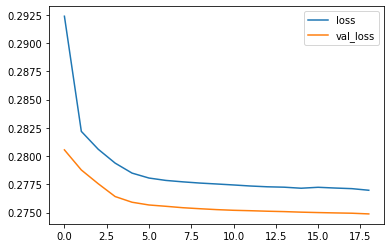

In [10]:
pd.DataFrame(history.history).filter(like="loss").plot()

In [11]:
sample_submission["CHURN"] = model.predict(test)
sample_submission.head()

,CHURN
user_id,
00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0.004150
000055d41c8a62052dd426592e8a4a3342bf565d,0.028749
000081dd3245e6869a4a9c574c7050e7bb84c2c8,0.020195
0000b76d2145d9445d9ff6b65c9ebc4196c89337,0.372347
0000bae5480628cf8fe51ad84bcb39772fc79224,0.352535


In [12]:
sample_submission.to_csv("nn_submission.csv")